[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/yue-sun/generative-art/blob/main/05_friday/02_gan_art.ipynb)

# Generative Adversarial Network (GAN) Art
Generative Adversarial Networks, or GANs, consist of a pair of neural networks: a Generator and a Discriminator. The Generator’s job is to fool the Discriminator by creating realistic images from a random seed, while the Discriminator’s job is to distinguish the real from the fake images.

As the Generator improves its output to fool the Discriminator, it learns underlying patterns and motifs of the training data. Once trained, it can then generate completely new images that resemble real ones. Below is an illustration of the basic GAN architecture.

![gan.jpeg](https://raw.githubusercontent.com/yue-sun/generative-art/main/05_friday/figs/gan.jpeg)

For example, GANs can be used to generate artwork that emulates famous paintings! The results below were obtained following this blog post on [Generating Art using GANs](https://medium.com/jovianml/generating-art-with-gans-352ceef3d51f). We will base our implementation below on the same architecture.

![artwork.gif](https://raw.githubusercontent.com/yue-sun/generative-art/main/05_friday/figs/artwork.gif)

In this tutorial, we will use GANs to generate custom Pokemon. This tutorial was inspired by the [Monster GANs](https://medium.com/@yvanscher/using-gans-to-create-monsters-for-your-game-c1a3ece2f0a0) blog post and uses pokemon images from the following [Pokemon Database](https://veekun.com/dex/downloads). In the end, our result will look something like this:

![pokemon.gif](https://raw.githubusercontent.com/yue-sun/generative-art/main/05_friday/figs/pokemon.gif)

## Getting started
Since we're training a neural network, we'll want to use a GPU. To do so, go to ``Runtime > Select runtime type`` and ensure that GPU is selected from the dropdown menu, then hit save.

Then, we'll clone the Github repo to access some supporting files for import.

In [ ]:
!git clone https://github.com/yue-sun/generative-art.git
%cd generative-art/05_friday

In [3]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tqdm.notebook import tqdm
from IPython.display import HTML
#from google.colab import files

# PyTorch machine learning modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

## Data loading and processing

In [4]:
# Specify data location and processing routine
dirname = "pokemon_icons/"
batch_size = 64
image_size = 96

In [5]:
# Convert images to tensors of the same size and normalize
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
transform_ds = transforms.Compose([transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                  ])

train_ds = ImageFolder(root=dirname, transform=transform_ds)
print('Number of examples:', len(train_ds))

Number of examples: 4144


In [6]:
# Augment dataset by performing horizontal flips of the images and cycling the hues at random
factor = 3
augment_ds = transforms.Compose([transforms.Resize(image_size),
                                 transforms.CenterCrop(image_size),
                                 transforms.ColorJitter(hue=0.2),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.ToTensor(),
                                 transforms.Normalize(*stats)
                                ])

datasets = [train_ds]
for i in range(factor - 1):
    datasets += [ImageFolder(root=dirname, transform=augment_ds)]
train_ds = ConcatDataset(datasets)
print('Number of examples after augmentation:', len(train_ds))

Number of examples after augmentation: 12432


In [7]:
# Create dataloader to load data in batches
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [8]:
# Helper functions to visualize image data
def denorm(img_tensors):
    return img_tensors*stats[1][0] + stats[0][0]

def show_images(images, nmax=64, figsize=(8,8)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64, figsize=(8,8)):
    for images, _ in dl:
        show_images(images, nmax, figsize)
        break

torch.Size([3, 96, 96])


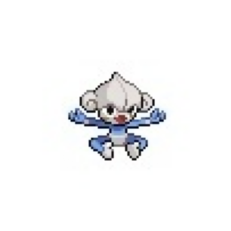

In [9]:
# Show an example image
image, _ = train_ds[np.random.randint(len(train_ds))]
print(image.size())
plt.imshow(denorm(image.permute(1,2,0)))
plt.axis('off')
plt.show()

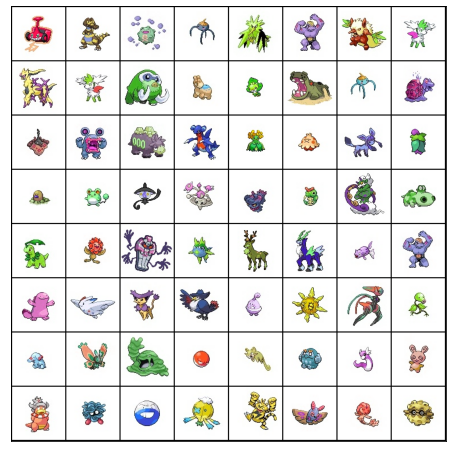

In [10]:
# Show an example batch
show_batch(train_dl)

## Moving to GPU

In [11]:
# Helper functions to move data and models to a GPU if available
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [12]:
# Select device and move data to device
device = get_default_device()
print(device)
train_dl = DeviceDataLoader(train_dl, device)

cpu


## Building the GAN

In [13]:
# Build discriminator model
class GaussianNoise(nn.Module):
    def __init__(self, std=0.1):
        super().__init__()
        self.std = std

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x
        
class Discriminator(nn.Module):
    def __init__(self, image_size):
        super(Discriminator, self).__init__()
        
        modules = []
        in_channels = 3
        out_channels = 64
        for i in range(int(np.log2(image_size)) - 2):
            modules.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(out_channels, momentum=0.8),
                nn.LeakyReLU(negative_slope=0.2),
                nn.Dropout(p=0.25),
                GaussianNoise(std=0.05)
            ))
            
            in_channels = out_channels
            out_channels *= 2
        
        self.main = nn.Sequential(*modules)
        
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input):
        out = self.main(input)
        return self.classifier(out)

discriminator = Discriminator(image_size)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.25, inplace=False)
      (4): GaussianNoise()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.25, inplace=False)
      (4): GaussianNoise()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Dropout(p=0.25, inplace=False)
      (4): GaussianNoise()
    )
    (3):

In [14]:
# Build generator model
class Palette(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        modules = [nn.Flatten()]
        features = [in_features, 128, 64]
        for i in range(len(features)-1):
            modules.append(nn.Sequential(
                nn.Linear(features[i], features[i+1], bias=True),
                nn.BatchNorm1d(features[i+1]),
                nn.LeakyReLU()
            ))

        modules.append(nn.Sequential(
            nn.Linear(features[-1], out_features, bias=True),
            nn.Tanh()
        ))
        
        self.main = nn.Sequential(*modules)
        
    def forward(self, input):
        return self.main(input)
    
    
class Generator(nn.Module):
    def __init__(self, image_size, latent_size=16):
        super(Generator, self).__init__()
        
        self.palette_size = 16
        self.red = Palette(latent_size, self.palette_size)
        self.green = Palette(latent_size, self.palette_size)
        self.blue = Palette(latent_size, self.palette_size)
        
        modules = []
        out_channels = 512
        modules.append(nn.Sequential(
            nn.ConvTranspose2d(latent_size, out_channels, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        ))
        
        in_channels = out_channels
        out_channels //= 2
        for i in range(int(np.log2(image_size)) - 3):
            modules.append(nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            ))
            
            in_channels = out_channels
            out_channels //= 2
        
        self.main = nn.Sequential(*modules)
        
        self.output = nn.Sequential(
            nn.ConvTranspose2d(in_channels, self.palette_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Softmax(dim=1),
        )
        
    def forward(self, input):
        h = self.main(input)
        x = self.output(h)

        r_key = self.red(input).view((-1, self.palette_size, 1, 1))
        g_key = self.green(input).view((-1, self.palette_size, 1, 1))
        b_key = self.blue(input).view((-1, self.palette_size, 1, 1))

        r_out = torch.sum(x*r_key, dim=1, keepdim=True)
        g_out = torch.sum(x*g_key, dim=1, keepdim=True)
        b_out = torch.sum(x*b_key, dim=1, keepdim=True)
        
        return torch.cat([r_out, g_out, b_out], dim=1)

latent_size = 16
generator = Generator(image_size, latent_size)
print(generator)

Generator(
  (red): Palette(
    (main): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Sequential(
        (0): Linear(in_features=16, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Linear(in_features=64, out_features=16, bias=True)
        (1): Tanh()
      )
    )
  )
  (green): Palette(
    (main): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Sequential(
        (0): Linear(in_features=16, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.0

torch.Size([64, 3, 64, 64])


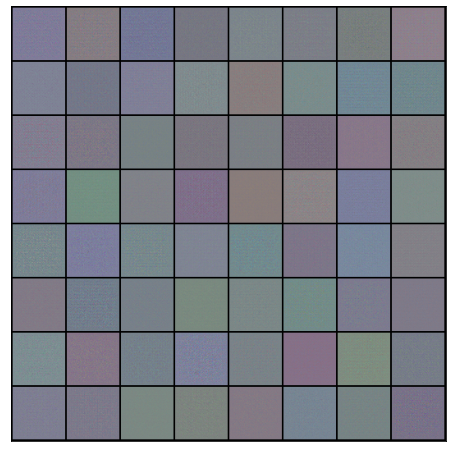

In [15]:
# Plot the output of an untrained generator
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [16]:
# Move models to device
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

## Training routines

In [17]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return real_loss.item(), fake_loss.item(), real_score, fake_score
    
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

def show_samples(latent_tensors, figsize=(8,8)):
    fake_images = generator(latent_tensors)
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(fake_images.cpu().detach()), nrow=8).permute(1,2,0))
    plt.show()

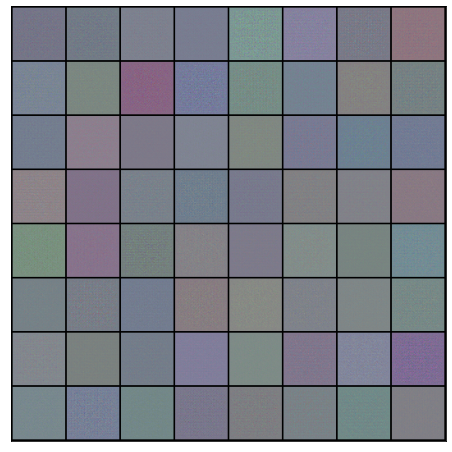

In [18]:
# Define a fixed random sample to evaluate during training
fixed_size = 64
fixed_latent = torch.randn(fixed_size, latent_size, 1, 1, device=device)
show_samples(fixed_latent);

## Training!

In [ ]:
def fit(epochs, lr, model_path):
    torch.cuda.empty_cache()
    # Intermediate results
    checkpoint = 5
    fake_images = torch.zeros(epochs//checkpoint, fixed_size, *image.shape)

    # Losses & scores
    losses_g = []
    losses_d_real = []
    losses_d_fake = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-8)
    opt_g = torch.optim.Adam(generator.parameters(), lr=2*lr, betas=(0.5, 0.999), weight_decay=1e-8)
    
    i = 0
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d_real, loss_d_fake, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d_real.append(loss_d_real)
        losses_d_fake.append(loss_d_fake)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        log = "Epoch [{}/{}], loss_g: {:.4f}, loss_d_real: {:.4f}, loss_d_fake: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}"
        print(log.format(epoch+1, epochs, loss_g, loss_d_real, loss_d_fake, real_score, fake_score))
    
        # Show generated images
        if (epoch+1)%checkpoint == 0:
            show_samples(fixed_latent)
            fake_images[i] = denorm(generator(fixed_latent).cpu().detach())
            i += 1
            
            results = {
                'history': {
                    'losses_g': losses_g,
                    'losses_d_real': losses_d_real,
                    'losses_d_fake': losses_d_fake,
                    'real_scores': real_scores,
                    'fake_scores': fake_scores,
                },
                'discriminator': discriminator.state_dict(),
                'generator': generator.state_dict(),
            }
            with open(model_path, 'wb') as f:
                torch.save(results, f)
    
    return fake_images

In [ ]:
# Specify the learning rate and number of epochs (iterations through the full dataset)
lr = 1e-4
epochs = 150
model_path = 'model.torch'

In [ ]:
# Train the networks
fake_images = fit(epochs, lr, model_path)

In [ ]:
# Read out the intermediate losses of saved model
model_path = 'pretrained.torch'
history = torch.load(model_path)['history']
losses_g, losses_d_real, losses_d_fake, real_scores, fake_scores = history.values()

In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6), sharex=True)
ax1.plot(losses_g, color='C1')
ax1.plot(losses_d_real, color='C0')
ax1.plot(losses_d_fake, color='C2')
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(['Generator', 'Discriminator - Real', 'Discriminator - Fake', ], frameon=False, fontsize=12)

ax2.plot(real_scores, color='C0')
ax2.plot(fake_scores, color='C2')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.legend(['Real', 'Fake'], frameon=False, fontsize=12)
fig.subplots_adjust(hspace=0.1)
plt.show()

In [ ]:
# Load pre-trained models
discriminator.load_state_dict(torch.load(model_path)['discriminator'])
generator.load_state_dict(torch.load(model_path)['generator'])

In [ ]:
# Plot the output of a trained generator on random seeds
xb = torch.randn(batch_size, latent_size, 1, 1)
show_images(generator(xb.to(device)).cpu(), figsize=(8,8))

In [ ]:
# Create an animation of the evolution of fake images during training
def animate_results(dl, fake_images, figsize=(16,8)):
    frames = fake_images.shape[0]
    nmax = fake_images.shape[1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
    ax1.set_xticks([]); ax1.set_yticks([])
    ax2.set_xticks([]); ax2.set_yticks([])

    for images, _ in dl:
        ax1.imshow(make_grid(denorm(images.detach().cpu()[:nmax]), nrow=8).permute(1,2,0))
        break

    im = ax2.imshow(make_grid(fake_images[0], nrow=8).permute(1,2,0))

    ax1.set_title('Example Training Batch', fontsize=18)
    ax2.set_title('Example Fake Images  |   Epochs: 5', fontsize=18)

    def animate(i):
        im.set_array(make_grid(fake_images[i], nrow=8).permute(1,2,0))
        ax2.set_title('Example Fake Images  |   Epochs: ' + str(5*(i + 1)), fontsize=18)
        return im,

    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=500, blit=True)
    plt.close(fig)
    return ani

In [ ]:
# Create animation
ani = animate_results(train_dl, fake_images)

# Display animation
HTML(ani.to_html5_video())

In [ ]:
# Save animation as a gif and download
ani.save('pokemon.gif', writer='pillow', fps=2)
files.download('pokemon.gif')